<a href="https://colab.research.google.com/github/SocialDragonsNeuromatch/NeuromatchProject/blob/main/notebooks/pearson_correlation_hcp_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# @title Install dependencies
!pip install pandas --quiet
!pip install seaborn --quiet
!pip install nilearn --quiet

     |████████████████████████████████| 9.6 MB 5.2 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import plotting, datasets

In [ ]:
# @title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download the task data

import os, requests, tarfile

fname = "hcp_task.tgz"
url = "https://osf.io/s4h8j/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")
      

Download hcp_task.tgz completed!


In [ ]:
# @title Download the rest data

import os, requests, tarfile

fname = "hcp_rest.tgz"
url = "https://osf.io/g759t/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")
      

Download hcp_rest.tgz completed!


In [ ]:
# @title Extract the task data in `HCP_DIR`
fname_ex = "hcp_task"
path_name = os.path.join(HCP_DIR, fname_ex)
if not os.path.exists(path_name):
  print(f"Extracting {fname_ex}.tgz...")
  with tarfile.open(f"{fname_ex}.tgz") as fzip:
    fzip.extractall(HCP_DIR)
else:
  print(f"File {fname_ex}.tgz has already been extracted.")

Extracting hcp_task.tgz...


In [ ]:
# @title Extract the rest data in `HCP_DIR`
fname_ex = "hcp_rest"
path_name = os.path.join(HCP_DIR, fname_ex)
if not os.path.exists(path_name):
  print(f"Extracting {fname_ex}.tgz...")
  with tarfile.open(f"{fname_ex}.tgz") as fzip:
    fzip.extractall(HCP_DIR)
else:
  print(f"File {fname_ex}.tgz has already been extracted.")

Extracting hcp_rest.tgz...


## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(os.path.join(HCP_DIR, "hcp_task", "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

print(region_info)

{'name': ['R_V1', 'R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_4', 'R_3b', 'R_FEF', 'R_PEF', 'R_55b', 'R_V3A', 'R_RSC', 'R_POS2', 'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT', 'R_MT', 'R_A1', 'R_PSL', 'R_SFL', 'R_PCV', 'R_STV', 'R_7Pm', 'R_7m', 'R_POS1', 'R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv', 'R_5m', 'R_5mv', 'R_23c', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL', 'R_SCEF', 'R_6ma', 'R_7Am', 'R_7PL', 'R_7PC', 'R_LIPv', 'R_VIP', 'R_MIP', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v', 'R_p24pr', 'R_33pr', 'R_a24pr', 'R_p32pr', 'R_a24', 'R_d32', 'R_8BM', 'R_p32', 'R_10r', 'R_47m', 'R_8Av', 'R_8Ad', 'R_9m', 'R_8BL', 'R_9p', 'R_10d', 'R_8C', 'R_44', 'R_45', 'R_47l', 'R_a47r', 'R_6r', 'R_IFJa', 'R_IFJp', 'R_IFSp', 'R_IFSa', 'R_p9-46v', 'R_46', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v', 'R_a10p', 'R_10pp', 'R_11l', 'R_13l', 'R_OFC', 'R_47s', 'R_LIPd', 'R_6a', 'R_i6-8', 'R_s6-8', 'R_43', 'R_OP4', 'R_OP1', 'R_OP2-3', 'R_52', 'R_RI', 'R_PFcm', 'R_PoI2', 'R_TA2', 'R_FOP4', 'R_MI', 'R

In [ ]:
region_name_list=region_info['name']
region_network_list=list(region_info['network'].reshape(len(region_name_list),))
region_name_array=np.array(region_name_list)
region_network_array=np.array(region_network_list)

region_number_array=np.array(range(len(region_name_list)))
default_number_array=region_number_array[region_network_array == 'Default']
default_name_array=region_name_array[region_network_array == 'Default']
print(default_number_array)
print(default_name_array.shape)

[ 11  24  25  27  73  74  78  80 122 124 127 128 138 171 191 205 254 258
 302 304 308 318 351]
(23,)


In [ ]:
a = [1,2]
b = [1,2,13,4,5]

c = list(set(a) | set(b))
c.sort()
print(c)

[1, 2, 4, 5, 13]


In [ ]:
SN_name = ["R_STSda","R_STSdp","R_STSvp","R_TPOJ1","R_TPOJ2","R_TPOJ3","R_STSva",
        "L_STSda","L_STSdp","L_STSvp","L_TPOJ1","L_TPOJ2","L_TPOJ3","L_STSva"]
SN_number = []


for name in SN_name:
  SN_number.append(region_name_list.index(name))
ROIs_number_list = list(set(SN_number) | set(list(default_number_array)))
ROIs_number_list.sort()
ROIs_number_array = np.array(ROIs_number_list)
print(ROIs_number_array)
ROIs_name_array = region_name_array[ROIs_number_array]

ROIs_name_list = list(ROIs_name_array)
print(ROIs_name_array)
print(ROIs_name_array.shape)

[ 11  24  25  27  73  74  78  80 122 124 127 128 129 138 139 140 171 175
 191 205 254 258 302 304 307 308 309 318 319 320 351 355]
['R_55b' 'R_PSL' 'R_SFL' 'R_STV' 'R_44' 'R_45' 'R_IFJa' 'R_IFSp' 'R_STGa'
 'R_A5' 'R_STSda' 'R_STSdp' 'R_STSvp' 'R_TPOJ1' 'R_TPOJ2' 'R_TPOJ3'
 'R_TGv' 'R_STSva' 'L_55b' 'L_SFL' 'L_45' 'L_IFJa' 'L_STGa' 'L_A5'
 'L_STSda' 'L_STSdp' 'L_STSvp' 'L_TPOJ1' 'L_TPOJ2' 'L_TPOJ3' 'L_TGv'
 'L_STSva']
(32,)


In [ ]:
# This uses the nilearn package
# @title Download `atlas.npz`

import os, requests, tarfile

fname = "atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")

with np.load(fname) as dobj:
  atlas = dict(**dobj)

coords = atlas['coords']
ROIs_coords = coords[ROIs_number_array]

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = EXPERIMENTS[experiment]['runs'][run]
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts



def load_evs(subject, experiment, run, dir):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment
    run (int) : 0-based run index, across all tasks

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           str(task_key), f"{cond}.txt")

    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list


def load_rest_timeseries(subject, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = run
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
my_exp = 'SOCIAL'
social_all_ts = []
for my_subj in range(N_SUBJECTS):
  two_runs_ts = []
  for my_run in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,dir=os.path.join(HCP_DIR, "hcp_task"), remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=os.path.join(HCP_DIR, "hcp_task"))
    two_cons_ts = []
    for idx in range(2):
      label = EXPERIMENTS[my_exp]['cond'][idx]
      sub_evs = evs[idx]
      for j in range(len(sub_evs)):
        if j == 0:
          con_ts = data[:,sub_evs[j]]
        else:
          con_ts = np.concatenate((con_ts,data[:,sub_evs[j]]),axis=-1)
      two_cons_ts.append(con_ts)
    two_runs_ts.append(two_cons_ts)
  social_all_ts.append(two_runs_ts)




In [ ]:
my_exp = 'LANGUAGE'
lan_all_ts = []
for my_subj in range(N_SUBJECTS):
  two_runs_ts = []
  for my_run in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,dir=os.path.join(HCP_DIR, "hcp_task"), remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=os.path.join(HCP_DIR, "hcp_task"))
    two_cons_ts = []
    for idx in range(2):
      label = EXPERIMENTS[my_exp]['cond'][idx]
      sub_evs = evs[idx]
      for j in range(len(sub_evs)):
        if j == 0:
          con_ts = data[:,sub_evs[j]]
        else:
          con_ts = np.concatenate((con_ts,data[:,sub_evs[j][sub_evs[j]<len(data[0])]]),axis=-1)
      two_cons_ts.append(con_ts)
    two_runs_ts.append(two_cons_ts)
  lan_all_ts.append(two_runs_ts)


In [ ]:
a = np.array([[1,1],[1,1]])
b = np.array([[0,0],[2,2]])

c = a - b

print(c)
print(np.sqrt(np.sum(np.square(c))))

[[ 1  1]
 [-1 -1]]
2.0


In [ ]:
def compute_matrix_dist(A,B):
  return np.corrcoef(A.reshape(1,len(A)*len(A[0])),B.reshape(1,len(B)*len(B[0])))[0][1]

ALL_SUBJECTS_MATRIX = []
MENTAL_REST = []
RANDOM_REST = []
MATH_REST = []
STORY_REST = []

MENTAL_ROIs_REST = []
RANDOM_ROIs_REST = []
MATH_ROIs_REST = []
STORY_ROIs_REST = []

LANGUA_REST = []
SOCIAL_REST = []
LANGUA_ROIs_REST = []
SOCIAL_ROIs_REST = []

MENTAL_STORY = []

MENTAL_ROIs_STORY = []

#SOCIAL_ts_REST = []
#SOCIAL_ts_ROIs_REST = []

for my_subj in range(N_SUBJECTS):
  mental_ts = np.concatenate((social_all_ts[my_subj][0][0],social_all_ts[my_subj][1][0]),axis=-1)
  random_ts = np.concatenate((social_all_ts[my_subj][0][1],social_all_ts[my_subj][1][1]),axis=-1)
  math_ts = np.concatenate((lan_all_ts[my_subj][0][0],lan_all_ts[my_subj][1][0]),axis=-1)
  story_ts = np.concatenate((lan_all_ts[my_subj][0][1],lan_all_ts[my_subj][1][1]),axis=-1)

  #social_ts = mental_ts - random_ts

  mental_matrix = np.corrcoef(mental_ts)
  random_matrix = np.corrcoef(random_ts)
  math_matrix = np.corrcoef(math_ts)
  story_matrix = np.corrcoef(story_ts)
  
  mental_ROIs_matrix = np.corrcoef(mental_ts[ROIs_number_array])
  random_ROIs_matrix = np.corrcoef(random_ts[ROIs_number_array])
  math_ROIs_matrix = np.corrcoef(math_ts[ROIs_number_array])
  story_ROIs_matrix = np.corrcoef(story_ts[ROIs_number_array])
  
  #social_ts_contrast_matrix = np.corrcoef(social_ts)
  #social_ts_contrast_ROIs_matrix = np.corrcoef(social_ts[ROIs_number_array])

  social_contrast_matrix = mental_matrix - random_matrix
  langua_contrast_matrix = story_matrix - math_matrix

  social_contrast_ROIs_matrix = mental_ROIs_matrix - random_ROIs_matrix
  langua_contrast_ROIs_matrix = story_ROIs_matrix - math_ROIs_matrix

  rest_ts = load_rest_timeseries(subject = my_subj, run = 1, dir=os.path.join(HCP_DIR, "hcp_rest"), remove_mean=True)
  rest_matrix = np.corrcoef(rest_ts)
  rest_ROIs_matrix = np.corrcoef(rest_ts[ROIs_number_array])
  
  SUBJECT_MATRIX = {'mental': mental_matrix, 'random': random_matrix, 'rest': rest_matrix, 'math': math_matrix, 'story': story_matrix,
            'mental_ROIs': mental_ROIs_matrix, 'random_ROIs': random_ROIs_matrix, 'rest_ROIs': rest_ROIs_matrix, 'math_ROIs': math_ROIs_matrix, 'story_ROIs': story_ROIs_matrix}
  ALL_SUBJECTS_MATRIX.append(SUBJECT_MATRIX)
  

  #whole brain mode network brain regions' correlation value
  MENTAL_REST.append(compute_matrix_dist(mental_matrix, rest_matrix))
  RANDOM_REST.append(compute_matrix_dist(random_matrix, rest_matrix))
  MATH_REST.append(compute_matrix_dist(math_matrix, rest_matrix))
  STORY_REST.append(compute_matrix_dist(story_matrix, rest_matrix))
  
  MENTAL_STORY.append(compute_matrix_dist(mental_matrix, story_matrix))
  MENTAL_ROIs_STORY.append(compute_matrix_dist(mental_ROIs_matrix, story_ROIs_matrix))

  SOCIAL_REST.append(compute_matrix_dist(social_contrast_matrix, rest_matrix))
  LANGUA_REST.append(compute_matrix_dist(langua_contrast_matrix, rest_matrix))

  #SOCIAL_ts_REST.append(compute_matrix_dist(social_ts_contrast_matrix, rest_matrix))

  #ROIs mode network brain regions' correlation value
  MENTAL_ROIs_REST.append(compute_matrix_dist(mental_ROIs_matrix, rest_ROIs_matrix))
  RANDOM_ROIs_REST.append(compute_matrix_dist(random_ROIs_matrix, rest_ROIs_matrix))
  MATH_ROIs_REST.append(compute_matrix_dist(math_ROIs_matrix, rest_ROIs_matrix))
  STORY_ROIs_REST.append(compute_matrix_dist(story_ROIs_matrix, rest_ROIs_matrix))
  
  SOCIAL_ROIs_REST.append(compute_matrix_dist(social_contrast_ROIs_matrix, rest_ROIs_matrix))
  LANGUA_ROIs_REST.append(compute_matrix_dist(langua_contrast_ROIs_matrix, rest_ROIs_matrix))

  #SOCIAL_ts_ROIs_REST.append(compute_matrix_dist(social_ts_contrast_ROIs_matrix, rest_ROIs_matrix))

  




In [ ]:
from scipy import stats
import scipy.stats

print('mental vs. rest')
print(np.mean(np.array(MENTAL_REST)))
#print(np.var(np.array(MENTAL_REST)))
print('random vs. rest')
print(np.mean(np.array(RANDOM_REST)))
#print(np.var(np.array(RANDOM_REST)))
print('math vs. rest')
print(np.mean(np.array(MATH_REST)))
#print(np.var(np.array(MATH_REST)))
print('story vs. rest')
print(np.mean(np.array(STORY_REST)))
#print(np.var(np.array(STORY_REST)))

print('social vs. rest')
print(np.mean(np.array(SOCIAL_REST)))
#print(np.var(np.array(STORY_REST)))

print('language vs. rest')
print(np.mean(np.array(LANGUA_REST)))
#print(np.var(np.array(STORY_REST)))

print('mental vs. story')
print(np.mean(np.array(MENTAL_STORY)))
#print(np.var(np.array(STORY_REST)))

t, pval = scipy.stats.ttest_rel(MENTAL_REST, STORY_REST)
print(t,pval)



mental vs. rest
106.99341248122111
random vs. rest
106.67189124944152
math vs. rest
104.58099792708248
story vs. rest
101.85901693673513
social vs. rest
149.5286403408942
language vs. rest
145.29729496123022
mental vs. story
86.81001518205069
5.4558147911585015 9.439904961562224e-08


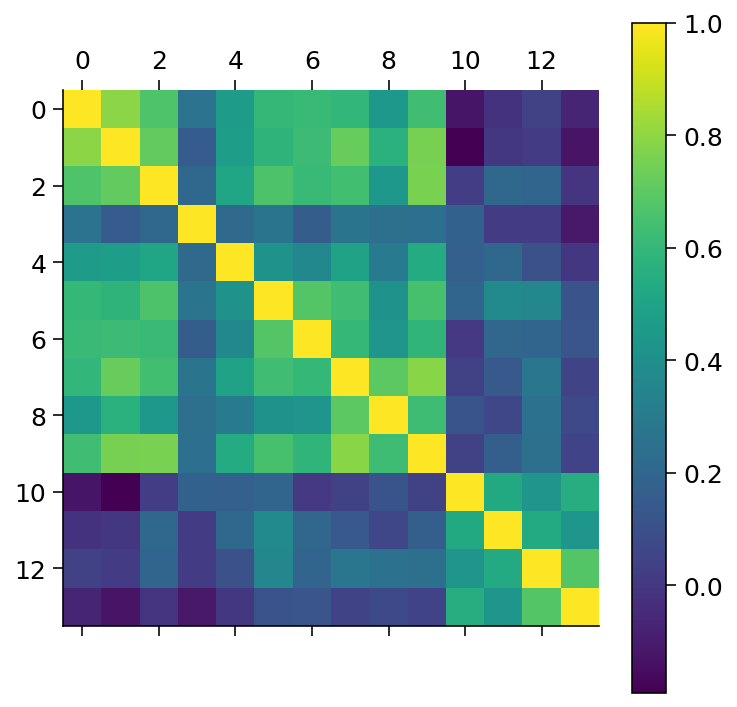

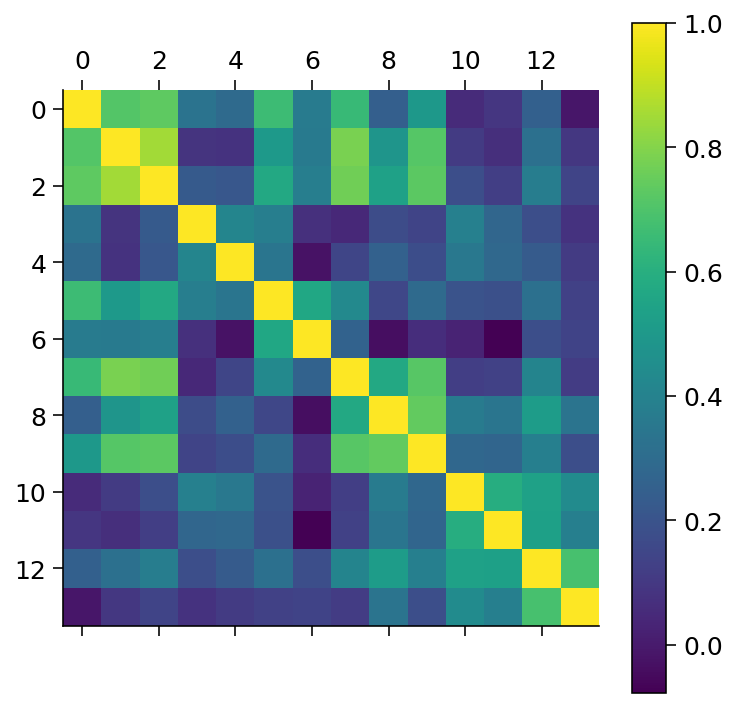

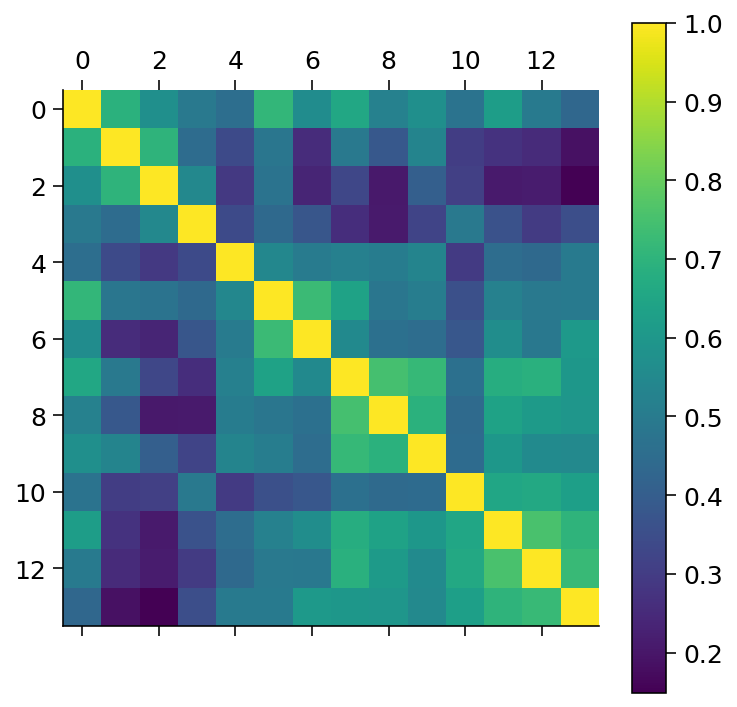

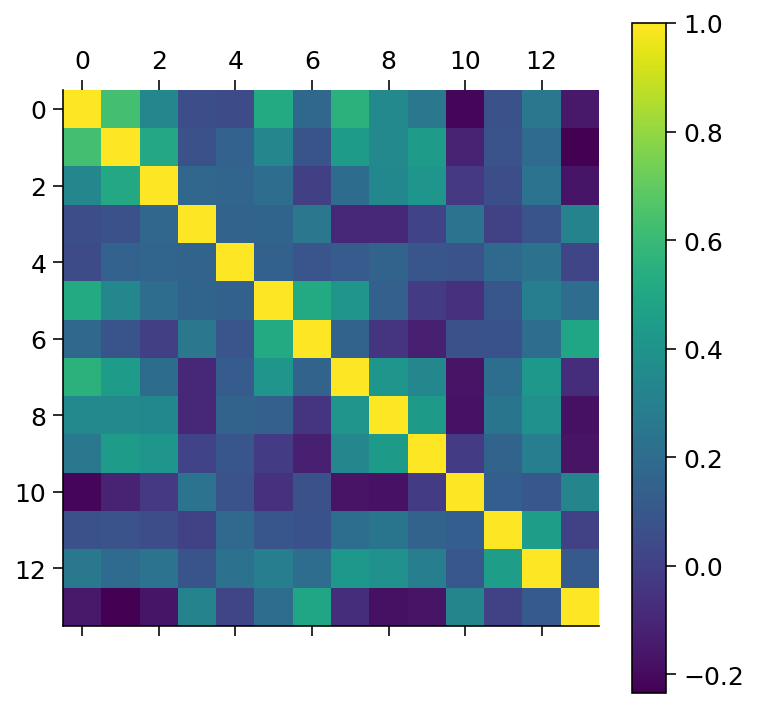

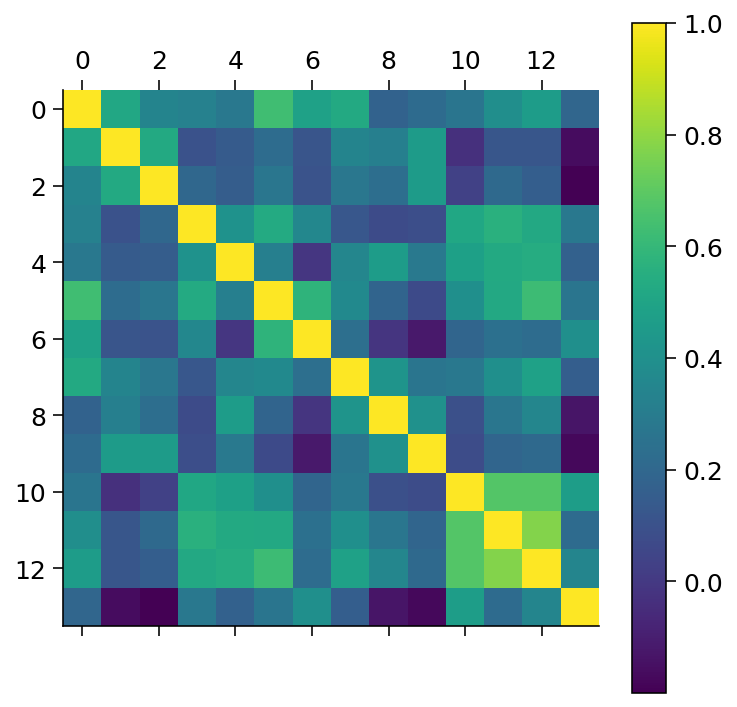

In [ ]:
plt.matshow(mental_ROIs_matrix)
plt.colorbar()
plt.matshow(random_ROIs_matrix)
plt.colorbar()
plt.matshow(rest_ROIs_matrix)
plt.colorbar()
plt.matshow(math_ROIs_matrix)
plt.colorbar()
plt.matshow(story_ROIs_matrix)
plt.colorbar()

In [ ]:
from scipy import stats
import scipy.stats

print('mental vs. rest')
print(np.mean(np.array(MENTAL_ROIs_REST)))
#print(np.var(np.array(MENTAL_REST)))
print('random vs. rest')
print(np.mean(np.array(RANDOM_ROIs_REST)))
#print(np.var(np.array(RANDOM_REST)))
print('math vs. rest')
print(np.mean(np.array(MATH_ROIs_REST)))
#print(np.var(np.array(MATH_REST)))
print('story vs. rest')
print(np.mean(np.array(STORY_ROIs_REST)))
#print(np.var(np.array(STORY_REST)))

print('social vs. rest')
print(np.mean(np.array(SOCIAL_ROIs_REST)))
#print(np.var(np.array(STORY_REST)))

print('language vs. rest')
print(np.mean(np.array(LANGUA_ROIs_REST)))
#print(np.var(np.array(STORY_REST)))

print('mental vs. story')
print(np.mean(np.array(MENTAL_ROIs_STORY)))

t, pval = scipy.stats.ttest_rel(MENTAL_ROIs_REST, STORY_ROIs_REST)
print(t,pval)

c = list(np.array(STORY_ROIs_REST) - np.array(MATH_ROIs_REST))
print(c.index(max(c)))

print(MENTAL_ROIs_REST)
print(RANDOM_ROIs_REST)
print(STORY_ROIs_REST)
print(MATH_ROIs_REST)

mental vs. rest
0.5135524529492304
random vs. rest
0.5193499852066796
math vs. rest
0.5284259402270973
story vs. rest
0.5400720900057182
social vs. rest
-0.0299316925800557
language vs. rest
0.043033672857107075
mental vs. story
0.5326292121718574
-4.55487210783943 7.328859450076472e-06
93
[0.23259052373953837, 0.6080801598962619, 0.590033213964442, 0.4972248987525839, 0.6437908492267265, 0.5716605312314597, 0.5637965741879956, 0.4785942774424118, 0.4185639755517551, 0.4802002228552912, 0.5420738153267092, 0.5522446534631069, 0.5721531792747142, 0.4215101695853085, 0.5897489316072353, 0.3973114762706079, 0.6055067960809023, 0.3589928308441931, 0.49992915827817, 0.3136617291091564, 0.48354086138646396, 0.731355040586245, 0.46842047830419986, 0.6017868936740448, 0.4426529215513354, 0.5990564302782329, 0.46011639724024134, 0.49023721998110115, 0.5765105046784983, 0.47691206296590233, 0.3396024738483553, 0.5646614954213063, 0.4651244501218381, 0.5142080787243596, 0.3715103789025792, 0.5474

In [ ]:
def compare_cell(condition_1, condition_2, region_row, region_col):
  con_1 = []
  con_2 = []
  for subject in range(N_SUBJECTS):
    con_1.append(ALL_SUBJECTS_MATRIX[subject][condition_1][region_row][region_col])
    con_2.append(ALL_SUBJECTS_MATRIX[subject][condition_2][region_row][region_col])
    
  t, pval = scipy.stats.ttest_rel(con_1, con_2)
  return t, pval

#whole brain
mental_rest_t_map = np.array([0]*N_PARCELS*N_PARCELS).reshape(N_PARCELS,N_PARCELS)
mental_rest_p_map = np.array([0]*N_PARCELS*N_PARCELS).reshape(N_PARCELS,N_PARCELS)
for region_row in range(N_PARCELS):
  for region_col in range(N_PARCELS):
    t, pval = compare_cell("mental","rest",region_row, region_col)
    mental_rest_t_map[region_row][region_col] = t
    mental_rest_p_map[region_row][region_col] = pval

#ROIS mode network
N_ROIS = len(ROIs_number_array)
mental_rest_ROIs_t_map = np.array([0]*N_ROIS*N_ROIS).reshape(N_ROIS,N_ROIS)
mental_rest_ROIs_p_map = np.array([0]*N_ROIS*N_ROIS).reshape(N_ROIS,N_ROIS)
for region_row in range(N_ROIS):
  for region_col in range(N_ROIS):
    t, pval = compare_cell("mental_ROIs","rest_ROIs",region_row, region_col)
    mental_rest_ROIs_t_map[region_row][region_col] = t
    mental_rest_ROIs_p_map[region_row][region_col] = pval
    
    



/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


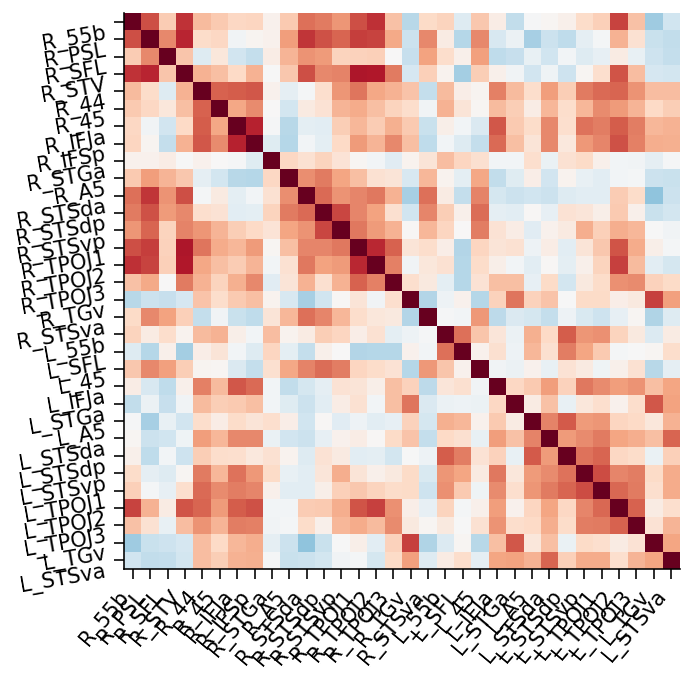

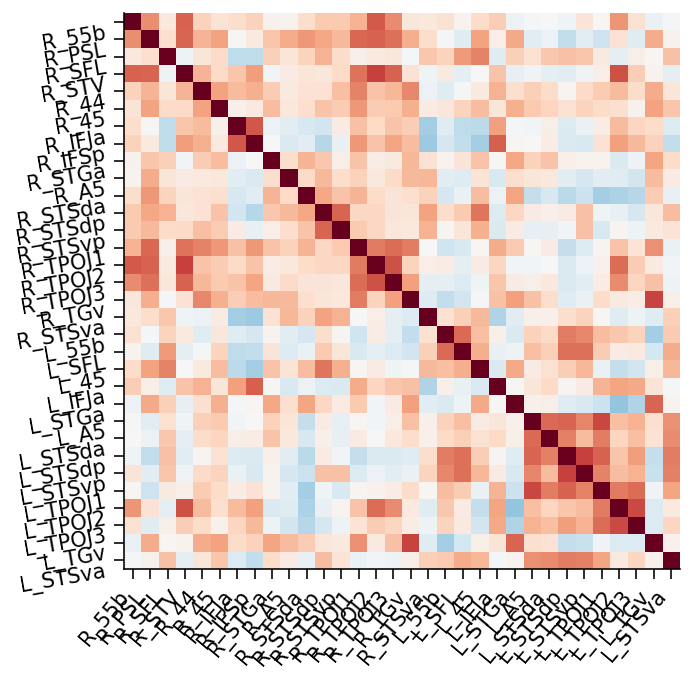

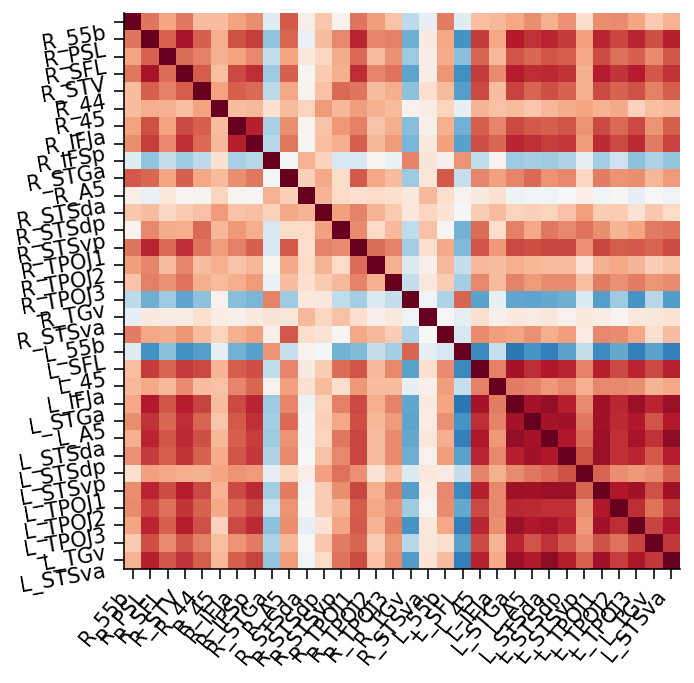

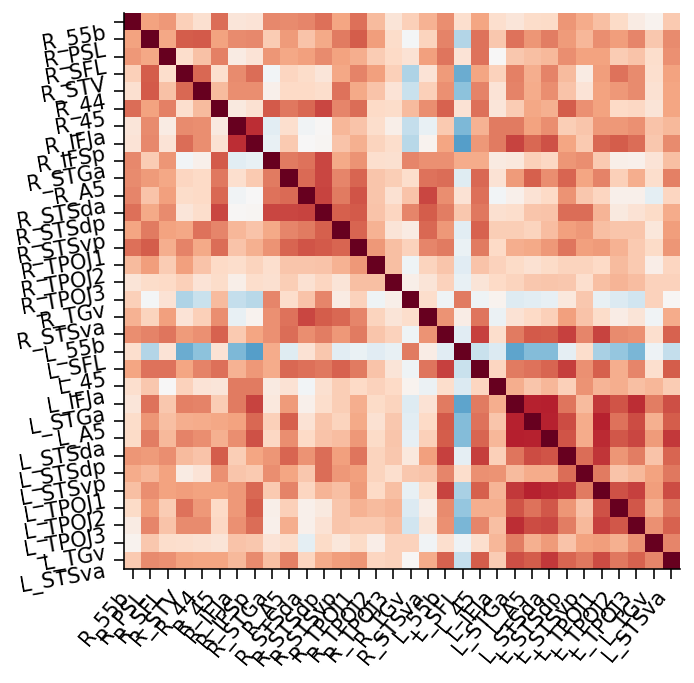

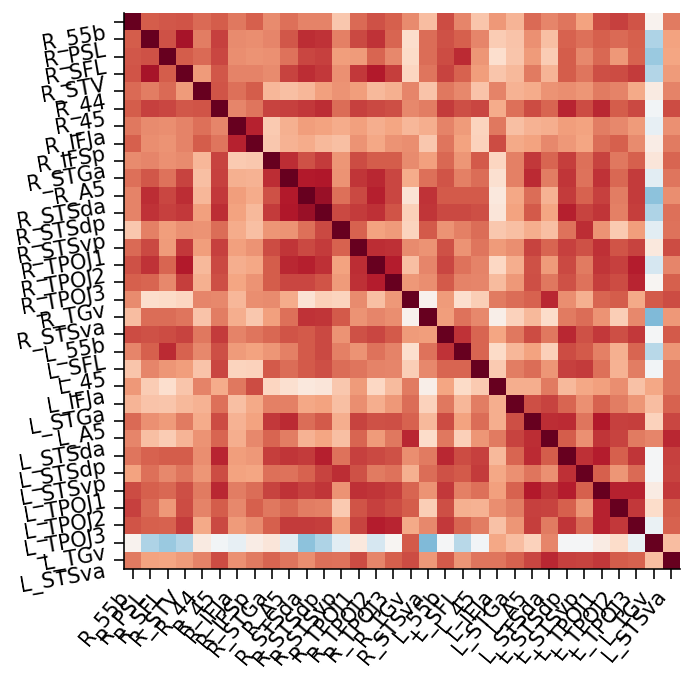

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


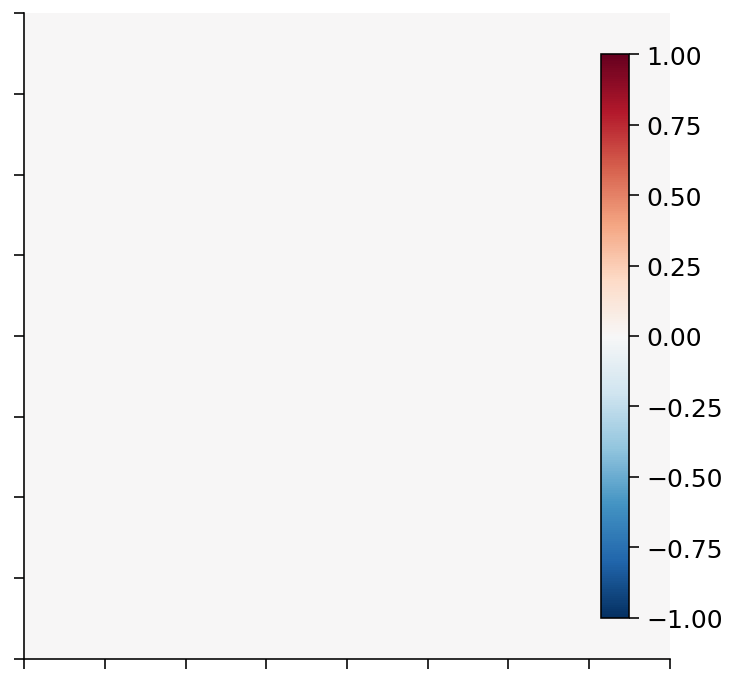

In [ ]:
eg_mental_ROIs_matrix = ALL_SUBJECTS_MATRIX[93]['mental_ROIs']
eg_random_ROIs_matrix = ALL_SUBJECTS_MATRIX[93]['random_ROIs']
eg_story_ROIs_matrix = ALL_SUBJECTS_MATRIX[93]['story_ROIs']
eg_math_ROIs_matrix = ALL_SUBJECTS_MATRIX[93]['math_ROIs']
eg_rest_ROIs_matrix = ALL_SUBJECTS_MATRIX[93]['rest_ROIs']

plotting.plot_matrix(eg_mental_ROIs_matrix, labels = ROIs_name_array, colorbar=False, vmax=1, vmin=-1, )
plotting.plot_matrix(eg_random_ROIs_matrix, labels = ROIs_name_array, colorbar=False, vmax=1, vmin=-1, )
plotting.plot_matrix(eg_math_ROIs_matrix, labels = ROIs_name_array, colorbar=False, vmax=1, vmin=-1, )
plotting.plot_matrix(eg_story_ROIs_matrix, labels = ROIs_name_array, colorbar=False, vmax=1, vmin=-1, )
plotting.plot_matrix(eg_rest_ROIs_matrix, labels = ROIs_name_array, colorbar=False, vmax=1, vmin=-1, )

plotting.plot_matrix(np.array([[0,0],[0,0]]),  colorbar=True, vmax=1, vmin=-1, )

New

In [ ]:
try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    # for Scitkit-Learn < v0.20.0
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

def get_covariance_matrix(time_series):
    estimator = GraphicalLassoCV()
    estimator.fit(time_series.T)
    return estimator.covariance_

import warnings
warnings.filterwarnings('ignore')

In [ ]:
cov_mental = []
cov_random = []
cov_math = []
cov_story = []

for my_subj in range(N_SUBJECTS):

    mental_ts = np.concatenate((social_all_ts[my_subj][0][0],social_all_ts[my_subj][1][0]),axis=-1)
    random_ts = np.concatenate((social_all_ts[my_subj][0][1],social_all_ts[my_subj][1][1]),axis=-1)
    math_ts = np.concatenate((lan_all_ts[my_subj][0][0],lan_all_ts[my_subj][1][0]),axis=-1)
    story_ts = np.concatenate((lan_all_ts[my_subj][0][1],lan_all_ts[my_subj][1][1]),axis=-1)
    
    break

    cov_mental.append(get_covariance_matrix(mental_ts))
    cov_random.append(get_covariance_matrix(random_ts))
    cov_math.append(get_covariance_matrix(math_ts))
    cov_story.append(get_covariance_matrix(story_ts))

    cov_default_mental.append(get_covariance_matrix(mental_ts[default_number_array]))
    cov_default_random.append(get_covariance_matrix(random_ts[default_number_array]))
    cov_default_math.append(get_covariance_matrix(math_ts[default_number_array]))
    cov_default_story.append(get_covariance_matrix(story_ts[default_number_array]))

    if my_subj == 2:
        break

In [ ]:
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import ShrunkCovariance
from sklearn.covariance import MinCovDet



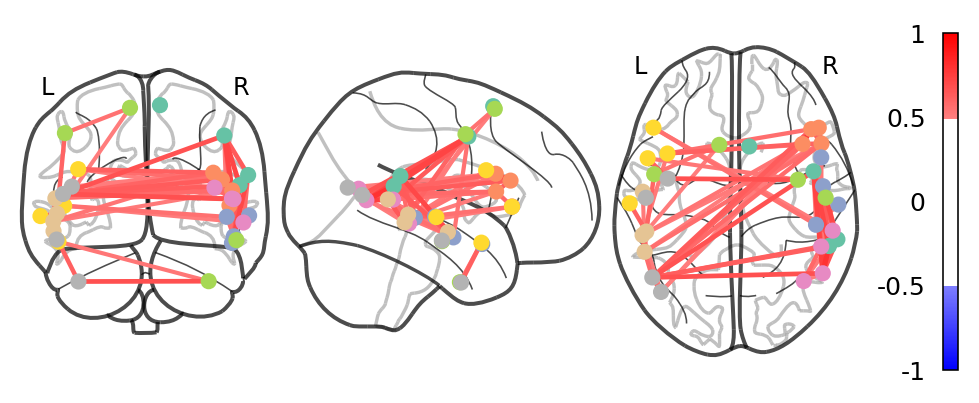

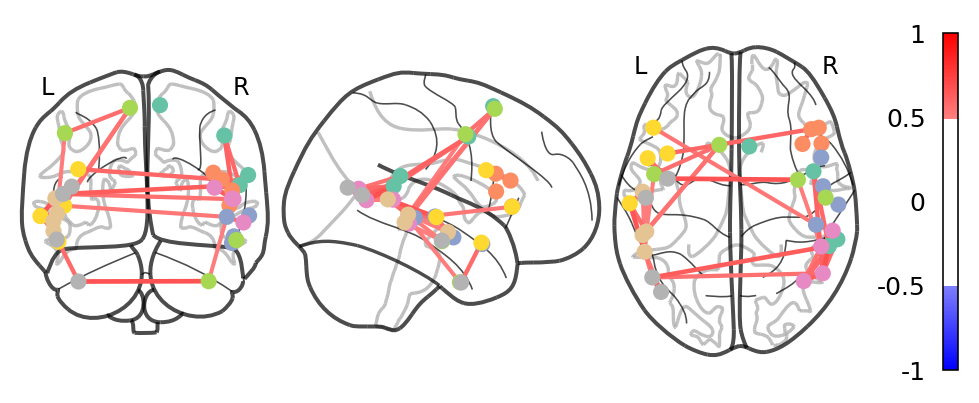

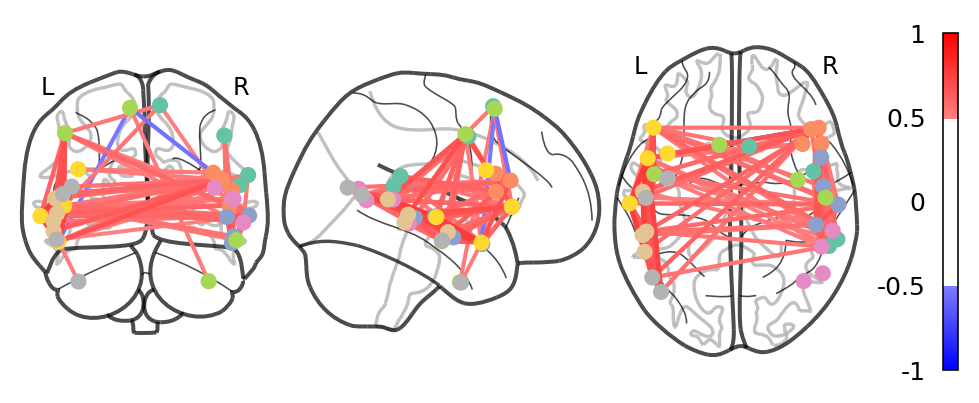

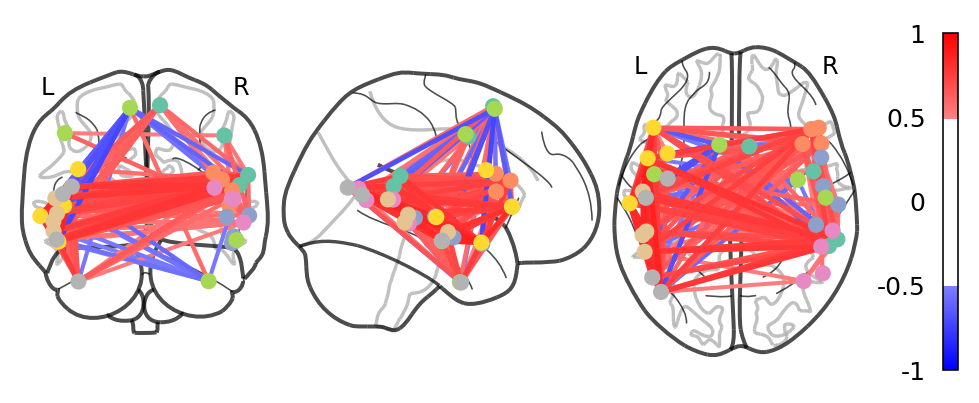

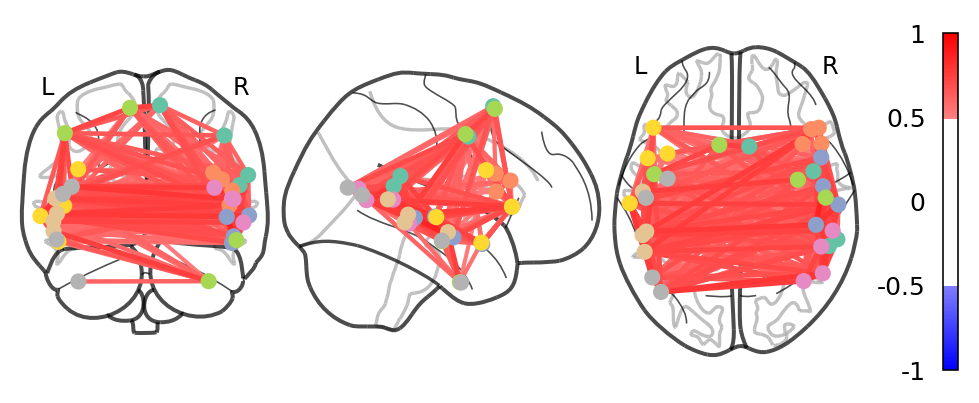

In [ ]:

plotting.plot_connectome(eg_mental_ROIs_matrix, ROIs_coords, colorbar = True, edge_vmin = -1, edge_vmax = 1, edge_threshold = 0.5)
plotting.plot_connectome(eg_random_ROIs_matrix, ROIs_coords, colorbar = True, edge_vmin = -1, edge_vmax = 1, edge_threshold = 0.5)
plotting.plot_connectome(eg_story_ROIs_matrix, ROIs_coords, colorbar = True, edge_vmin = -1, edge_vmax = 1, edge_threshold = 0.5)
plotting.plot_connectome(eg_math_ROIs_matrix, ROIs_coords, colorbar = True, edge_vmin = -1, edge_vmax = 1, edge_threshold = 0.5)
plotting.plot_connectome(eg_rest_ROIs_matrix, ROIs_coords, colorbar = True, edge_vmin = -1, edge_vmax = 1, edge_threshold = 0.5)